---
title: "2023_Laborversuch_Stuttgart_Bruchlasten"
author: "Kyell Jensen"
date: "2024-07-09"
format: pdf
editor: visual
---

# 2023_Laborversuch_Stuttgart_Bruchlasten

Nutze eine geeignete Python 3.11 Umgebung (z. B. virtuelle Environment) und installiere das Paket TreeCableCalc (TCC) inklusive kj_core und kj_logger und weiteren requirements.

## Laden der Arbeitsumgebung

Es werden zuerst benötigte Standard-Pakete und dann TCC importiert. Fehler beim Import von TCC sind ggf. Bugs. TCC nutzt eine gemeinsame CodeBasis mit den zwei Paketen PicusTreeQinetic (PTQ) und TreeMotion (TMS). Dieser gemeinsame Code ist in die Pakete kj_core (Core-Package) und kj_logger ausgelagert (individualisiertes Logging des Verarbeitungs-Prozesses). Diese sollte i. d. R. über die requirements mit installiert werden.

### Public Imports

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from typing import Dict, List

### Import TreeCableCalc

Das Paket TreeCableCalc wurde von Kyell Jensen zum einfachen Analysieren, Plotten und zur Interpretation der TXT bzw. CSV-Messdaten erstellt. Es ist ausgelegt für die Daten der Zugprüfmaschine im Institut für Fördertechnik und Logistik der Universität Stuttgart (https://www.ift.uni-stuttgart.de/institut/abteilungen/seiltechnologie/zerstoerende_seilpruefung/). Das Packet ist auf GitHub verfügbar (https://github.com/kyellsen/treecablecalc). Nachfolgend wird das Packet und einige dort definierten Klassen importiert.

In [2]:
import treecablecalc as tcc

from treecablecalc.classes.measurement import Measurement
from treecablecalc.classes.measurement_version import MeasurementVersion
from treecablecalc.classes.series import Series
from treecablecalc.classes.system import System
from treecablecalc.classes.data_tcc import DataTCC
from treecablecalc.classes.brand import Brand

# Test
tcc.help()


    Provides detailed guidance on setting up and using the treecablecalc package.

    Setup:
        The setup function initializes the treecablecalc package with user-defined settings.
        It configures logging, data management, database management, plotting, and the operational environment for data analysis.

        Example Usage:
            config, log_manager, data_manager, database_manager, plot_manager = setup('/path/to/directory', 'debug', safe_logs_to_file=True)

    Main Components:
        DataTCC:
            Represents data specific to the Tree Cable Calculation (TCC) experiments, including measurement and metadata.

    Managers:
        DataManager:
            Manages the data flow within the package, including registering listeners for data changes.

        DatabaseManager:
            Handles database interactions, ensuring efficient data storage and retrieval.

        PlotManager:
            Manages the creation and customization of plots for data visualiza

### Definition der Pfade

Lege Pfade für Daten-Importe, Daten-Exporte etc. fest (ggf. anpassen an eigene Verzeichnisstruktur)

In [3]:
# Main
main_path = Path(r"C:\kyellsen\005_Projekte\2024_BA\032_Laborversuch_2023_Stuttgart")
analyse_name = r"2023_Laborversuch_Stuttgart_Bruchlasten"
data_path = Path(
    r"C:\kyellsen\005_Projekte\2023_TreeCableCalc\021_Daten_Clean")  # Für alle Daten-Importe des Projektes gemeinsam
working_directory = main_path / "030_Analysen" / analyse_name / "working_directory"  # Für alle Daten-Exporte des Projektes gemeinsam

source_db_name = "TreeCableCalc_Stuttgart_2024-05-29.db"
source_db = data_path / source_db_name

### Initialisierung von TreeCableCalc und Datenbankverbindung

Die Funktion 'tcc.setup' erstellt Instanzen spezifischer Klassen, die für das Paket notwendig sind (CONFIG, LOG_MANAGER, DATA_MANAGER, DATABASE_MANAGER, PLOT_MANAGER).
Die Methode DATABASE_MANAGER.duplicate() erstellt eine sichere Arbeitskopie der Datenbank.

In [4]:
CONFIG, LOG_MANAGER, DATA_MANAGER, DATABASE_MANAGER, PLOT_MANAGER = tcc.setup(working_directory=str(working_directory),
                                                                              log_level="info")
DATABASE_MANAGER.duplicate(database_path=str(source_db))
DATABASE_MANAGER.connect(db_name=str(source_db_name))
series_list: List[Series] = DATABASE_MANAGER.load(class_name=Series)
print(series_list)

2024-07-09 09:46:36 [INFO] kj_logger.update_config: <kj_logger.LogManager object at 0x000002336E24EA90> initialized - update_config! Code: 000
2024-07-09 09:46:36 [INFO] kj_core.core_config.set_working_directory: The directory C:\kyellsen\005_Projekte\2024_BA\032_Laborversuch_2023_Stuttgart\030_Analysen\2023_Laborversuch_Stuttgart_Bruchlasten\working_directory\tcc was successfully created.
2024-07-09 09:46:36 [INFO] kj_core.core_config.set_working_directory: Working directory set to C:\kyellsen\005_Projekte\2024_BA\032_Laborversuch_2023_Stuttgart\030_Analysen\2023_Laborversuch_Stuttgart_Bruchlasten\working_directory\tcc!
2024-07-09 09:46:36 [INFO] kj_core.core_config.__init__: <treecablecalc.config.Config object at 0x000002336E24FB50> initialized! Code: 001
2024-07-09 09:46:36 [INFO] treecablecalc.config.__init__: <treecablecalc.config.Config object at 0x000002336E24FB50> initialized! Code: 002
2024-07-09 09:46:36 [INFO] treecablecalc.setup: tcc: Setup treecablecalc package!
2024-07-09

[<Series(series_id=1, description=2010-02-01_Freeworker, filepath_csv=C:/kyellsen/005_Projekte/2023_TreeCableCalc/021_Daten_Clean/2010-01-01_csv)>, <Series(series_id=2, description=2023-01-10_HAWK, filepath_csv=C:/kyellsen/005_Projekte/2023_TreeCableCalc/021_Daten_Clean/2023-01-10_csv)>]


### Selektieren der Messreihe und Messungen

Die erste Messreihe (series_list[0]) war eine Messreihe der Freeworker GmbH in 2010. Für diese Auswertung wird nur die zweite Messreihe (series_list[1]) mit den neuen Daten aus 2023 verwendet.

In [5]:
series_1 = series_list[1]
series_1

<Series(series_id=2, description=2023-01-10_HAWK, filepath_csv=C:/kyellsen/005_Projekte/2023_TreeCableCalc/021_Daten_Clean/2023-01-10_csv)>

Eine geringe Anzahl an Messungen wurde im Messprotokoll in der Datenbank als Fehlerhaft markiert. Diese werden ausgeschlossen bei der Analyse. Die Liste measurement_list enthält nachfolgend alle zu Auswertungen geeigneten Instanzen der Klasse Measurement.

In [6]:
measurement_list = [m for m in series_1.measurement if
                    m.execute != "dont_use" and m.series.description == "2023-01-10_HAWK"]
#measurement_list

## Material und Methoden, Beschreibung des Untersuchungsgegenstandes

Die Methode Measurement.get_summary_dict() lädt für die Messung in der Datenbank hinterlegte Medadaten. Diese werden in Schleife zu Tabelle zusammengefügt.

In [7]:
dict_list = []
for m in measurement_list:
    new_dict = m.get_summary_dict()  # None == ALL
    dict_list.append(new_dict)

df = pd.DataFrame(dict_list)
df

,measurement_id,series_id,sample_id,system_name,brand,producer,lifespan,load_ztv,pre_tension_load,color,diameter,fiber_type,elongation_properties,expansion_insert_count,shock_absorber_count,failure_loc,note
0,64,2,64,cobra 4t statisch,cobra,Gleistein,12,4,8,black,18.0,PP,dynamic/semi-static,2,0,spleisende_links,None
1,65,2,65,cobra 4t statisch,cobra,Gleistein,12,4,8,black,18.0,PP,dynamic/semi-static,2,0,spleisende_links,None
2,66,2,66,cobra 4t statisch,cobra,Gleistein,12,4,8,black,18.0,PP,dynamic/semi-static,0,0,spleisende_links,None
3,67,2,67,cobra 4t dynamisch,cobra,Gleistein,12,4,8,black,18.0,PP,dynamic/semi-static,0,1,ruckdaempfer,None
4,68,2,68,cobra 4t dynamisch,cobra,Gleistein,12,4,8,black,18.0,PP,dynamic/semi-static,2,1,ruckdaempfer,None
5,69,2,69,cobra 4t dynamisch,cobra,Gleistein,12,4,8,black,18.0,PP,dynamic/semi-static,2,1,ruckdaempfer,None
6,70,2,70,boa 4t dynamisch,boa,Gleistein,12,4,8,black/red,24.0,PP,dynamic/semi-static,0,1,ruckdaempfer,None
7,71,2,71,boa 4t dynamisch,boa,Gleistein,12,4,8,black/red,24.0,PP,dynamic/semi-static,2,1,ruckdaempfer,None
8,72,2,72,boa 4t dynamisch,boa,Gleistein,12,4,8,black/red,24.0,PP,dynamic/semi-static,2,1,ruckdaempfer,None
9,73,2,73,treeSafe 4t statisch schlaufen,drayer,Liros,8,4,8,black/green/yellow/blue,18.0,PES,semi-static,0,0,spleisende_links,None


### Überblick über den Untersuchungsgegenstand

Die Daten werden zusammenfassend ausgewertet, um einen Überklick über alle Messungen zu erstellen.

In [8]:
# Gesamtanzahl der Einträge
total_entries = len(df)
# Anzahl der einzigartigen Werte für system_name
unique_system_names = df['system_name'].nunique()
# Alle einzigartigen Werte für brand, alphabetisch sortiert
unique_brands_list = sorted(df['brand'].unique().tolist())
# Markenliste als lesbare Zeichenkette formatieren
unique_brands_str = ', '.join(unique_brands_list)
# Ausprägungen von load_ztv zählen
load_ztv_counts = df['load_ztv'].value_counts().sort_index().to_dict()
# Anzahl der Einträge mit shock_absorber_count == 1
shock_absorber_count_1 = len(df[df['shock_absorber_count'] == 1])
# Ergebnisse in einem DataFrame speichern
summary_df = pd.DataFrame({
    'Marken': [unique_brands_str],
    'Systeme Gesamtanzahl': [unique_system_names],
    'Samples Gesamtanzahl': [total_entries],
    'Samples mit Ruckdämpfer Anzahl': [shock_absorber_count_1]
})
# Add counts of each unique load_ztv value to the result DataFrame
for key, value in load_ztv_counts.items():
    summary_df[f'Samples MBL {key}t Anzahl'] = value

summary_df.T

,0
Marken,"boa, cobra, drayer, gefa, gleistein"
Systeme Gesamtanzahl,19
Samples Gesamtanzahl,52
Samples mit Ruckdämpfer Anzahl,16
Samples MBL 2t Anzahl,10
Samples MBL 4t Anzahl,24
Samples MBL 7t Anzahl,3
Samples MBL 8t Anzahl,15


Latex-Export: In BA als "Laborversuch, Material und Methoden, Untersuchungsgegenstand - Überblick KS im Versuch"

In [9]:
# Transpose the DataFrame for better readability
result_df_transposed = summary_df.T

# Konvertierung des DataFrames in eine LaTeX-Tabelle
latex_string = result_df_transposed.to_latex(index=True, escape=True, column_format="ll",
                                             header=False)

latex_table = f"""
\\begin{{table}}[h]
\\centering
    \\caption{{Laborversuch, Material und Methoden, Untersuchungsgegenstand - Überblick \\Gls{{KS}} im Versuch}}
    {latex_string}
    \\label{{tab:Laborversuch_Zusammenfassung_Kronensicherungen}}
\\end{{table}}
"""

print(latex_table)


\begin{table}[h]
\centering
    \caption{Laborversuch, Material und Methoden, Untersuchungsgegenstand - Überblick \Gls{KS} im Versuch}
    \begin{tabular}{ll}
\toprule
\midrule
Marken & boa, cobra, drayer, gefa, gleistein \\
Systeme Gesamtanzahl & 19 \\
Samples Gesamtanzahl & 52 \\
Samples mit Ruckdämpfer Anzahl & 16 \\
Samples MBL 2t Anzahl & 10 \\
Samples MBL 4t Anzahl & 24 \\
Samples MBL 7t Anzahl & 3 \\
Samples MBL 8t Anzahl & 15 \\
\bottomrule
\end{tabular}

    \label{tab:Laborversuch_Zusammenfassung_Kronensicherungen}
\end{table}


### Untersuchungsgegenstand System-Ebene

In [10]:
# Definieren Sie die Spalten, die gruppiert werden sollen
group_columns = [
    'system_name', 'brand', 'producer', 'lifespan',
    'pre_tension_load', 'color', 'diameter', 'fiber_type', 'elongation_properties'
]

# Erstellen eines Dictionarys für die Aggregationsmethoden
agg_dict = {col: 'first' for col in group_columns if col != 'system_name'}

# Gruppieren nach 'system_name' und anwenden der Aggregationsmethoden
system_df = df.groupby('system_name', as_index=False).agg(agg_dict)

# Sortieren, wobei Groß- und Kleinschreibung unberücksichtigt bleiben
system_df = system_df.assign(
    system_name_lower=system_df['system_name'].str.lower()
).sort_values(by='system_name_lower').drop('system_name_lower', axis=1)

# Den resultierenden DataFrame anzeigen
system_df

,system_name,brand,producer,lifespan,pre_tension_load,color,diameter,fiber_type,elongation_properties
0,ArboLine 4t schlaufen,gleistein,Gleistein,8,8,black/green/red,NaN,PES,semi-static
3,boa 2t dynamisch,boa,Gleistein,12,8,black/red,14.0,PP,dynamic/semi-static
4,boa 4t dynamisch,boa,Gleistein,12,8,black/red,24.0,PP,dynamic/semi-static
5,boa 8t dynamisch,boa,Liros,12,16,black/red,30.0,PES,dynamic/semi-static
6,boa 8t statisch,boa,Liros,12,16,black/red,30.0,PES,dynamic/semi-static
7,cobra 2t dynamisch,cobra,Gleistein,12,8,black,14.0,PP,dynamic/semi-static
8,cobra 4t dynamisch,cobra,Gleistein,12,8,black,18.0,PP,dynamic/semi-static
9,cobra 4t statisch,cobra,Gleistein,12,8,black,18.0,PP,dynamic/semi-static
10,cobra 8t dynamisch,cobra,Gleistein,12,16,black,28.0,PP,dynamic/semi-static
11,cobra 8t statisch,cobra,Gleistein,12,16,black,28.0,PP,dynamic/semi-static


Latex-Export: In BA als "Laborversuch, Material und Methoden, Untersuchungsgegenstand - Systeme im Versuch"

In [11]:
# Übersetzung der Spaltennamen ins Deutsche
system_df = system_df.rename(columns={
    'Systemname': 'Systemname',
    'brand': 'Marke',
    'producer': 'Produzent',
    'lifespan': 'Jahre',
    'pre_tension_load': 'Einf.',
    'color': 'Farbe',
    'diameter': 'Durchmesser',
    'fiber_type': 'Faser',
    'elongation_properties': 'Dehnungseigenschaften'
})

# Konvertierung des DataFrames in eine LaTeX-Tabelle
latex_string = system_df.to_latex(index=False, escape=True, column_format="lllrrlrll",
                                             header=True, float_format="{:0.0f}".format)
# Einfügen des adjustbox-Teils
latex_table = f"""
\\begin{{table}}[h]
\\centering
    \\caption{{Laborversuch, Material und Methoden, Untersuchungsgegenstand - Systeme im Versuch}}
    \\begin{{adjustbox}}{{max width=\\textwidth}}
    {latex_string}
    \\end{{adjustbox}}
    \\label{{tab:Laborversuch_Systeme}}
\\end{{table}}
"""

print(latex_table)


\begin{table}[h]
\centering
    \caption{Laborversuch, Material und Methoden, Untersuchungsgegenstand - Systeme im Versuch}
    \begin{adjustbox}{max width=\textwidth}
    \begin{tabular}{lllrrlrll}
\toprule
system\_name & Marke & Produzent & Jahre & Einf. & Farbe & Durchmesser & Faser & Dehnungseigenschaften \\
\midrule
ArboLine 4t schlaufen & gleistein & Gleistein & 8 & 8 & black/green/red & NaN & PES & semi-static \\
boa 2t dynamisch & boa & Gleistein & 12 & 8 & black/red & 14 & PP & dynamic/semi-static \\
boa 4t dynamisch & boa & Gleistein & 12 & 8 & black/red & 24 & PP & dynamic/semi-static \\
boa 8t dynamisch & boa & Liros & 12 & 16 & black/red & 30 & PES & dynamic/semi-static \\
boa 8t statisch & boa & Liros & 12 & 16 & black/red & 30 & PES & dynamic/semi-static \\
cobra 2t dynamisch & cobra & Gleistein & 12 & 8 & black & 14 & PP & dynamic/semi-static \\
cobra 4t dynamisch & cobra & Gleistein & 12 & 8 & black & 18 & PP & dynamic/semi-static \\
cobra 4t statisch & cobra & Gleist

### Untersuchungsgegenstand Sample-Ebene

In [12]:
samples_df = df[['measurement_id', 'system_name', 'expansion_insert_count', 'shock_absorber_count', 'failure_loc', 'note']]
samples_df

,measurement_id,system_name,expansion_insert_count,shock_absorber_count,failure_loc,note
0,64,cobra 4t statisch,2,0,spleisende_links,None
1,65,cobra 4t statisch,2,0,spleisende_links,None
2,66,cobra 4t statisch,0,0,spleisende_links,None
3,67,cobra 4t dynamisch,0,1,ruckdaempfer,None
4,68,cobra 4t dynamisch,2,1,ruckdaempfer,None
5,69,cobra 4t dynamisch,2,1,ruckdaempfer,None
6,70,boa 4t dynamisch,0,1,ruckdaempfer,None
7,71,boa 4t dynamisch,2,1,ruckdaempfer,None
8,72,boa 4t dynamisch,2,1,ruckdaempfer,None
9,73,treeSafe 4t statisch schlaufen,0,0,spleisende_links,None


Latex-Export: In BA als "Laborversuch, Material und Methoden, Untersuchungsgegenstand - Samples im Versuch"

In [13]:
# Übersetzung der Spaltennamen ins Deutsche
samples_df = samples_df.rename(columns={
    'measurement_id': 'id',
    'system_name': 'System_Name',
    'expansion_insert_count': 'Spreizb.',
    'shock_absorber_count': 'Ruckd.',
    'failure_loc': 'Versagensort',
    'note': 'Bemerkung',
})

# Konvertierung des DataFrames in eine LaTeX-Tabelle
latex_string = samples_df.to_latex(index=False, escape=True, column_format="rlrrll",
                                             header=True, float_format="{:0.0f}".format)
latex_table = f"""
\\begin{{table}}[h]
\\centering
    \\caption{{Laborversuch, Material und Methoden, Untersuchungsgegenstand - Samples im Versuch}}
    \\begin{{adjustbox}}{{max width=\\textwidth}}
    {latex_string}
    \\end{{adjustbox}}
    \\label{{tab:Laborversuch_Samples}}
\\end{{table}}
"""

print(latex_table)


\begin{table}[h]
\centering
    \caption{Laborversuch, Material und Methoden, Untersuchungsgegenstand - Samples im Versuch}
    \begin{adjustbox}{max width=\textwidth}
    \begin{tabular}{rlrrll}
\toprule
id & System\_Name & Spreizb. & Ruckd. & Versagensort & Bemerkung \\
\midrule
64 & cobra 4t statisch & 2 & 0 & spleisende\_links & NaN \\
65 & cobra 4t statisch & 2 & 0 & spleisende\_links & NaN \\
66 & cobra 4t statisch & 0 & 0 & spleisende\_links & NaN \\
67 & cobra 4t dynamisch & 0 & 1 & ruckdaempfer & NaN \\
68 & cobra 4t dynamisch & 2 & 1 & ruckdaempfer & NaN \\
69 & cobra 4t dynamisch & 2 & 1 & ruckdaempfer & NaN \\
70 & boa 4t dynamisch & 0 & 1 & ruckdaempfer & NaN \\
71 & boa 4t dynamisch & 2 & 1 & ruckdaempfer & NaN \\
72 & boa 4t dynamisch & 2 & 1 & ruckdaempfer & NaN \\
73 & treeSafe 4t statisch schlaufen & 0 & 0 & spleisende\_links & NaN \\
74 & treeSafe 4t statisch schlaufen & 0 & 0 & spleisende\_rechts & NaN \\
75 & treeSafe 4t statisch schlaufen & 0 & 0 & spleisende\_li

## Ergbenisse

### Import der Messdaten

Die Datenbank enthält alle Metadaten zur den Systemen, Samples, Messungen etc.
Die Messdaten der Zugprüfanlage liegen in einzelnen txt.-Dateien.

Die Methode load_with_features() lädt die Messdaten aus den TXT Daten. Die enthalten nur die spalten Zeit, Kraft und Länge.
Es werden zusätzliche Werte (features) wie Weg und Dehnung berechnet.

- selection_mode="default": Es werden keine bestimmten bereiche selektiert
- selection_until="end": Die Messwerte beleiben bis zum Ende erhalten
- measurement_version_name="version_for_mbl": Einer Measurement können verschiedene MeasurementVersion, also Auswertungsalternativen, zugeordnet werden. Der Parameter dient als Beschreibung einer Version.
- update_existing=False: Bestehende gleichnamige Auswertungen in der Datenbank werden nicht überschrieben (setze auf True für Neuerstellung, Achtung Laufzeitsensibel)
- filter_data=True: Die Rohdaten werden gefiltert, um Rauschen zu minimieren (df.rolling(window=window, center=True).mean(), für f (Kraft) window = 31, für x (Weg) window = 11).
- null_offset_f=False: Es wird kein null-offset der Kraft durchgeführt, um gemessene Bruchlasten nicht zu verfälschen
- fit_model=False: Es wird keine Polynomapproximation durchgeführt (nicht möglich ohne selektion anpassbarer Bereiche)

In [14]:
plot_flag = True

for m in measurement_list:
    m.load_with_features(selection_mode="default", selection_until="end",
                         measurement_version_name="version_for_mbl", update_existing=False,
                         filter_data=True, null_offset_f=False, fit_model=False, plot_filter=plot_flag,
                         plot_f_vs_e=plot_flag)

2024-07-09 09:46:38 [INFO] treecablecalc.classes.measurement.load_from_csv: Start loading TCC data from CSV for 'Measurement(id=64, series_id=2)'
2024-07-09 09:46:38 [INFO] treecablecalc.classes.data_tcc.create_from_csv: Created new '<treecablecalc.classes.data_tcc.DataTCC object at 0x0000023370D85750>'
2024-07-09 09:46:38 [INFO] treecablecalc.classes.measurement_version.create_from_csv: Created new 'MeasurementVersion: measurement_version_id: None, measurement_version_name: version_for_mbl, measurement_id: 64'
2024-07-09 09:46:38 [INFO] treecablecalc.classes.measurement.load_from_csv: New measurement_version 'version_for_mbl' created: 'MeasurementVersion: measurement_version_id: 1, measurement_version_name: version_for_mbl, measurement_id: 64'
2024-07-09 09:46:38 [INFO] treecablecalc.classes.measurement.load_from_csv: Start loading TCC data from CSV for 'Measurement(id=65, series_id=2)'
2024-07-09 09:46:38 [INFO] treecablecalc.classes.data_tcc.create_from_csv: Created new '<treecablec

Die Measurement.get_param_df() lädt für die erstelle MeasurementVersion deskriptive statistische Werte, insbesondere für Dehnung (e) und Kraft (f). Dabei werden mangels Polynom auf lineare Interpolation zurückgegriffen, um Dehnungswerte bei spezifischen Kräften zuermitteln.
Nachfolgend besonders relevant ist der Parameter "f_max", also die maximal gemessene Kraft während der Zugprüfung. Diese wird als Systembruchlast (SBL) angenommen.

In [15]:
df_list = []
for m in measurement_list:
    df = m.get_param_df(use_interp1d=True, use_poly1d=False,
                        measurement_version_names=["version_for_mbl"])  # None == ALL
    df_list.append(df)

df = pd.concat(df_list, ignore_index=True)
df

2024-07-09 09:47:32 [INFO] treecablecalc.classes.measurement_version.get_e_by_f_interp1d: MeasurementVersion: measurement_version_id: 28, measurement_version_name: version_for_mbl, measurement_id: 91 - Force 70.0 not in the range of the measurement, returning NAN
2024-07-09 09:47:32 [INFO] treecablecalc.classes.measurement_version.get_e_by_f_interp1d: MeasurementVersion: measurement_version_id: 29, measurement_version_name: version_for_mbl, measurement_id: 92 - Force 70.0 not in the range of the measurement, returning NAN
2024-07-09 09:47:32 [INFO] treecablecalc.classes.measurement_version.get_e_by_f_interp1d: MeasurementVersion: measurement_version_id: 30, measurement_version_name: version_for_mbl, measurement_id: 93 - Force 70.0 not in the range of the measurement, returning NAN
2024-07-09 09:47:32 [INFO] treecablecalc.classes.measurement_version.get_e_by_f_interp1d: MeasurementVersion: measurement_version_id: 47, measurement_version_name: version_for_mbl, measurement_id: 110 - Force

,measurement_version_id,measurement_version_name,measurement_id,system_name,brand,selection_mode,selection_until,filter_flag,e_by_f_method,null_offset,...,note,e_at_load_ztv_5,e_at_load_ztv_10,e_at_load_ztv_20,e_at_load_ztv_50,e_at_load_ztv_100,e_by_f_2,e_by_f_4,e_by_f_8,e_by_f_16
0,1,version_for_mbl,64,cobra 4t statisch,cobra,default,end,True,interp1d,None,...,None,5.210917,5.498906,6.447269,11.805526,16.721131,5.210917,5.498906,6.447269,10.752325
1,2,version_for_mbl,65,cobra 4t statisch,cobra,default,end,True,interp1d,None,...,None,5.943152,6.358988,7.323272,12.655621,17.771215,5.943152,6.358988,7.323272,11.540141
2,3,version_for_mbl,66,cobra 4t statisch,cobra,default,end,True,interp1d,None,...,None,4.056944,4.098026,4.941386,7.652608,12.283144,4.056944,4.098026,4.941386,6.735708
3,4,version_for_mbl,67,cobra 4t dynamisch,cobra,default,end,True,interp1d,None,...,None,4.376078,4.841898,6.273778,9.567126,14.994939,4.376078,4.841898,6.273778,8.487204
4,5,version_for_mbl,68,cobra 4t dynamisch,cobra,default,end,True,interp1d,None,...,None,8.109323,8.326631,9.976651,15.741414,21.648537,8.109323,8.326631,9.976651,14.372544
5,6,version_for_mbl,69,cobra 4t dynamisch,cobra,default,end,True,interp1d,None,...,None,6.516411,7.076456,8.157480,14.029274,19.899227,6.516411,7.076456,8.157480,12.939403
6,7,version_for_mbl,70,boa 4t dynamisch,boa,default,end,True,interp1d,None,...,None,6.835641,7.887014,21.249000,12.974721,18.893841,6.835641,7.887014,21.249000,11.742563
7,8,version_for_mbl,71,boa 4t dynamisch,boa,default,end,True,interp1d,None,...,None,6.069429,7.241390,9.585325,14.940135,21.130459,6.069429,7.241390,9.585325,13.464457
8,9,version_for_mbl,72,boa 4t dynamisch,boa,default,end,True,interp1d,None,...,None,5.135301,7.116228,9.652058,14.795036,21.008517,5.135301,7.116228,9.652058,13.391109
9,10,version_for_mbl,73,treeSafe 4t statisch schlaufen,drayer,default,end,True,interp1d,None,...,None,3.364158,4.189945,5.291326,8.871203,13.485629,3.364158,4.189945,5.291326,7.696250


### Berechnung relevanter Feature für alle Samples

Die Bruchlast der Samples wird hier in Bezug gesetzt mit der MBL des Systems entsprechend ZTV-Baumpflege.

- load_reserve: Absolute Bruchlastreserve in kN
- load_reserve_percent: Relative Bruchlastreserve in %

Positive Werte bedeuten, dass eine Reserve vorhanden ist, negative das die Systeme die MBL unterschreiten.

Anschließend Kategorisierung der Samples entsprechend ihrer relativen Reserve.

In [16]:
# Berechnen der Lastreserve
df['load_reserve'] = df['f_max'] - df['load_ztv']
df['load_reserve_percent'] = df['load_reserve'] / df['load_ztv'] * 100

optimal_min = 15  #percent
optimal_max = 30  #percent to oversize
# Erstellen der Flag-Spalte
df['passed'] = df['f_max'] > df['load_ztv']
df['oversize'] = df['load_reserve_percent'] > optimal_max
df['optimal'] = (df['load_reserve_percent'] >= optimal_min) & (
        df['load_reserve_percent'] <= optimal_max)
df = df[~df['measurement_id'].isin(
    [97, 99])]  # Verwendung von systemfremder kreuzeder Baumschlaufe, schwächer als originale treeSafe 8t Schlaufe

# Kürzen der Systemnamen, Entfernen des Strings " schlaufe" und Ersetzen von " dynamisch" und " statisch"
df.loc[:, 'system_name'] = df['system_name'].str.replace(' schlaufen', '', regex=False)
df.loc[:, 'system_name'] = df['system_name'].str.replace(' dynamisch', ' dyn.', regex=False)
df.loc[:, 'system_name'] = df['system_name'].str.replace(' statisch', ' stat.', regex=False)
df

,measurement_version_id,measurement_version_name,measurement_id,system_name,brand,selection_mode,selection_until,filter_flag,e_by_f_method,null_offset,...,e_at_load_ztv_100,e_by_f_2,e_by_f_4,e_by_f_8,e_by_f_16,load_reserve,load_reserve_percent,passed,oversize,optimal
0,1,version_for_mbl,64,cobra 4t stat.,cobra,default,end,True,interp1d,None,...,16.721131,5.210917,5.498906,6.447269,10.752325,14.810387,37.025968,True,True,False
1,2,version_for_mbl,65,cobra 4t stat.,cobra,default,end,True,interp1d,None,...,17.771215,5.943152,6.358988,7.323272,11.540141,14.488097,36.220241,True,True,False
2,3,version_for_mbl,66,cobra 4t stat.,cobra,default,end,True,interp1d,None,...,12.283144,4.056944,4.098026,4.941386,6.735708,15.047355,37.618388,True,True,False
3,4,version_for_mbl,67,cobra 4t dyn.,cobra,default,end,True,interp1d,None,...,14.994939,4.376078,4.841898,6.273778,8.487204,6.474645,16.186613,True,False,True
4,5,version_for_mbl,68,cobra 4t dyn.,cobra,default,end,True,interp1d,None,...,21.648537,8.109323,8.326631,9.976651,14.372544,4.345968,10.864920,True,False,False
5,6,version_for_mbl,69,cobra 4t dyn.,cobra,default,end,True,interp1d,None,...,19.899227,6.516411,7.076456,8.157480,12.939403,5.226935,13.067338,True,False,False
6,7,version_for_mbl,70,boa 4t dyn.,boa,default,end,True,interp1d,None,...,18.893841,6.835641,7.887014,21.249000,11.742563,9.361936,23.404839,True,False,True
7,8,version_for_mbl,71,boa 4t dyn.,boa,default,end,True,interp1d,None,...,21.130459,6.069429,7.241390,9.585325,13.464457,8.646709,21.616773,True,False,True
8,9,version_for_mbl,72,boa 4t dyn.,boa,default,end,True,interp1d,None,...,21.008517,5.135301,7.116228,9.652058,13.391109,8.782129,21.955323,True,False,True
9,10,version_for_mbl,73,treeSafe 4t stat.,drayer,default,end,True,interp1d,None,...,13.485629,3.364158,4.189945,5.291326,7.696250,19.197742,47.994355,True,True,False


Erstellung Tabelle "Laborversuch, Ergebnisse - Samples Bestanden"

In [17]:
# Berechnungen
samples_n = df.shape[0]

samples_passed_n = df['passed'].sum()
samples_passed_percent = samples_passed_n / samples_n * 100
samples_passed_not_percent = 100 - samples_passed_percent

samples_oversize_n = df['oversize'].sum()
samples_oversize_percent = samples_oversize_n / samples_n * 100

samples_optimal_n = df['optimal'].sum()
samples_optimal_percent = samples_optimal_n / samples_n * 100

# Erstellung der Liste von Dictionaries für den DataFrame
data_list = [
    {'variable': 'samples_n', 'Variable': 'Samples gesamt', 'Anzahl': samples_n, 'Prozent': None},
    {'variable': 'samples_passed', 'Variable': 'Samples bestanden', 'Anzahl': samples_passed_n,
     'Prozent': samples_passed_percent},
    {'variable': 'samples_passed_not', 'Variable': 'Samples nicht bestanden', 'Anzahl': samples_n - samples_passed_n,
     'Prozent': samples_passed_not_percent},
    {'variable': 'samples_oversize', 'Variable': 'Samples überdimensioniert', 'Anzahl': samples_oversize_n,
     'Prozent': samples_oversize_percent},
    {'variable': 'samples_optimal', 'Variable': 'Samples optimal', 'Anzahl': samples_optimal_n,
     'Prozent': samples_optimal_percent}
]

# Erstellung des DataFrames
samples_passed_df = pd.DataFrame(data_list)
#samples_passed_df

In [18]:
# Auswahl der gewünschten Spalten
selected_columns = ['Variable', 'Anzahl', 'Prozent']
selected_samples_passed_df = samples_passed_df[selected_columns]

# Konvertierung des DataFrames in eine LaTeX-Tabelle
latex_string = selected_samples_passed_df.to_latex(index=False, escape=True, column_format="lrr",
                                                   float_format="{:0.2f}".format)

latex_table = f"""
\\begin{{table}}[h]
\\centering
    \\caption{{Laborversuch, Ergebnisse - Samples Bestanden}}
    {latex_string}
    \\label{{tab:Laborversuch_Samples_Summary}}
\\end{{table}}
"""

print(latex_table)


\begin{table}[h]
\centering
    \caption{Laborversuch, Ergebnisse - Samples Bestanden}
    \begin{tabular}{lrr}
\toprule
Variable & Anzahl & Prozent \\
\midrule
Samples gesamt & 50 & NaN \\
Samples bestanden & 41 & 82.00 \\
Samples nicht bestanden & 9 & 18.00 \\
Samples überdimensioniert & 24 & 48.00 \\
Samples optimal & 10 & 20.00 \\
\bottomrule
\end{tabular}

    \label{tab:Laborversuch_Samples_Summary}
\end{table}


In [19]:
# Metrikenliste definieren
metrics = ['count', 'mean', 'std', 'min', 'median', 'max']

# Berechnung der spezifischen statistischen Kennzahlen
summary_stats_all_load_reserve = df[['load_reserve']].agg(metrics).T
summary_stats_all_load_reserve_percent = df[['load_reserve_percent']].agg(metrics).T

# Berechnung der spezifischen statistischen Kennzahlen für die Gruppierung nach 'load_ztv'
summary_stats_group_load_reserve = df.groupby('load_ztv')[['load_reserve']].agg(metrics)
summary_stats_group_load_reserve_percent = df.groupby('load_ztv')[['load_reserve_percent']].agg(metrics)

# 'load_ztv' als neue Spalte einfügen und mit 'overall' für die gesamten Statistiken versehen
summary_stats_all_load_reserve.insert(0, 'load_ztv', 'overall')
summary_stats_all_load_reserve_percent.insert(0, 'load_ztv', 'overall')

# Gruppierte Daten zurücksetzen, um 'load_ztv' als Spalte zu behandeln
summary_stats_group_load_reserve = summary_stats_group_load_reserve.reset_index()
summary_stats_group_load_reserve_percent = summary_stats_group_load_reserve_percent.reset_index()

# Spalten umbenennen für Konsistenz
rename_list = ['load_ztv'] + metrics
summary_stats_all_load_reserve.columns = rename_list
summary_stats_all_load_reserve_percent.columns = rename_list
summary_stats_group_load_reserve.columns = rename_list
summary_stats_group_load_reserve_percent.columns = rename_list

# Kombinieren der DataFrames
summary_stats_load_reserve = pd.concat([summary_stats_all_load_reserve, summary_stats_group_load_reserve],
                                       ignore_index=True)
summary_stats_load_reserve_percent = pd.concat(
    [summary_stats_all_load_reserve_percent, summary_stats_group_load_reserve_percent], ignore_index=True)

# Ausgabe des kombinierten DataFrames
summary_stats_load_reserve

,load_ztv,count,mean,std,min,median,max
0,overall,50.0,11.776503,13.083534,-16.936258,10.758323,41.793516
1,20,10.0,8.155758,2.821991,4.638581,7.696564,11.904839
2,40,24.0,13.482586,14.676274,-8.354258,11.925016,41.793516
3,70,3.0,-10.324495,6.285741,-16.936258,-9.611677,-4.425549
4,80,13.0,16.512228,10.508573,2.719548,13.900484,31.404903


In [20]:
# Konvertierung des kombinierten DataFrames in eine LaTeX-Tabelle
latex_string = summary_stats_load_reserve.to_latex(index=False, escape=True, column_format="lrrrrrr",
                                                   float_format="{:0.2f}".format)

latex_table = f"""
\\begin{{table}}[h]
    \caption[Laborversuch, Ergebnisse - Bruchlastreserven der Samples absolut]{{Laborversuch, Ergebnisse - Bruchlastreserven der Samples absolut in kN, gruppiert nach MBL entsprechend ZTV-Baumpflege}}
    \\centering
    {latex_string}
    \\label{{tab:Laborversuch_Samples_load_reserve_absolut}}
\\end{{table}}
"""

print(latex_table)

# Konvertierung des kombinierten DataFrames in eine LaTeX-Tabelle
latex_string = summary_stats_load_reserve_percent.to_latex(index=False, escape=True, column_format="lrrrrrr",
                                                           float_format="{:0.2f}".format)

latex_table = f"""
\\begin{{table}}[h]
    \\caption{{Laborversuch, Ergebnisse - Bruchlastreserven der Samples relativ zur MBL nach ZTV in Prozent, gruppiert nach MBL entsprechend ZTV-Baumpflege}}
    \\centering
    {latex_string}
    \\label{{tab:Laborversuch_Samples_load_reserve_relativ}}
\\end{{table}}
"""

print(latex_table)


\begin{table}[h]
    \caption[Laborversuch, Ergebnisse - Bruchlastreserven der Samples absolut]{Laborversuch, Ergebnisse - Bruchlastreserven der Samples absolut in kN, gruppiert nach MBL entsprechend ZTV-Baumpflege}
    \centering
    \begin{tabular}{lrrrrrr}
\toprule
load\_ztv & count & mean & std & min & median & max \\
\midrule
overall & 50.00 & 11.78 & 13.08 & -16.94 & 10.76 & 41.79 \\
20 & 10.00 & 8.16 & 2.82 & 4.64 & 7.70 & 11.90 \\
40 & 24.00 & 13.48 & 14.68 & -8.35 & 11.93 & 41.79 \\
70 & 3.00 & -10.32 & 6.29 & -16.94 & -9.61 & -4.43 \\
80 & 13.00 & 16.51 & 10.51 & 2.72 & 13.90 & 31.40 \\
\bottomrule
\end{tabular}

    \label{tab:Laborversuch_Samples_load_reserve_absolut}
\end{table}


\begin{table}[h]
    \caption{Laborversuch, Ergebnisse - Bruchlastreserven der Samples relativ zur MBL nach ZTV in Prozent, gruppiert nach MBL entsprechend ZTV-Baumpflege}
    \centering
    \begin{tabular}{lrrrrrr}
\toprule
load\_ztv & count & mean & std & min & median & max \\
\midrule
overall

2024-07-09 09:47:33 [INFO] matplotlib.category.update: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-09 09:47:33 [INFO] matplotlib.category.update: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-09 09:47:33 [INFO] matplotlib.category.update: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-09 09:47:33 [INFO] matplotlib.category.update: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


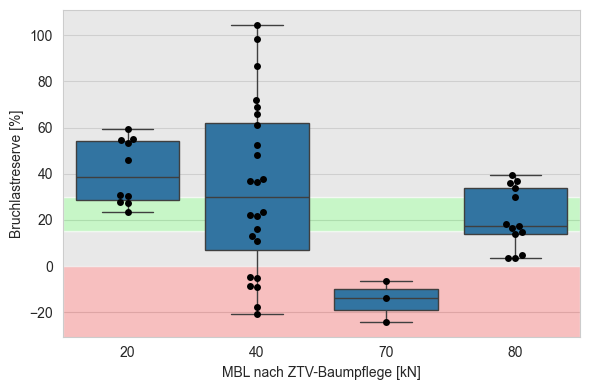

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Erstellen des Boxplots mit Punkten für jeden Sample
fig = plt.figure(figsize=(6, 4))
sns.boxplot(x='load_ztv', y='load_reserve_percent', data=df)
sns.swarmplot(x='load_ztv', y='load_reserve_percent', data=df, color='k', alpha=1)

# Definieren der Bereiche und Farben
plt.axhspan(-1e6, 0, facecolor='lightcoral', alpha=0.5)
plt.axhspan(0, optimal_min, facecolor='lightgrey', alpha=0.5)
plt.axhspan(optimal_min, optimal_max, facecolor='lightgreen', alpha=0.5)
plt.axhspan(optimal_max, 1e6, facecolor='lightgrey', alpha=0.5)

# Titel und Achsenbeschriftungen hinzufügen
#plt.title('Bruchlastreserven aller Samples in % der MBL nach ZTV')
plt.xlabel('MBL nach ZTV-Baumpflege [kN]')
plt.ylabel('Bruchlastreserve [%]')
plt.tight_layout()

# Speichern des Plots
PLOT_MANAGER.save_plot(fig, filename=f"sample_load_reserve_percent", subdir="mbl", auto_close=False)

# Plot anzeigen
plt.show()

Erstellung Tabelle "Laborversuch, Ergebnisse - Systeme Bestanden"

In [22]:
# Zusammenfassung der Daten
summary_df = df.groupby(['system_name', 'load_ztv']).agg(
    samples_n=("f_max", "size"),
    passed_samples_n=('passed', 'sum'),
    oversize_samples_n=('oversize', 'sum'),
    optimal_samples_n=('optimal', 'sum'),
    min_f_max=("f_max", "min"),
    mean_f_max=("f_max", "mean"),
    max_f_max=("f_max", "max"),
    load_reserve_min=('load_reserve', lambda x: round(x.min(), 2)),
    load_reserve_mean=('load_reserve', lambda x: round(x.mean(), 2)),
    load_reserve_max=('load_reserve', lambda x: round(x.max(), 2)),
    load_reserve_percent_min=('load_reserve_percent', lambda x: round(x.min(), 2)),
    load_reserve_percent_mean=('load_reserve_percent', lambda x: round(x.mean(), 2)),
    load_reserve_percent_max=('load_reserve_percent', lambda x: round(x.max(), 2))).reset_index()

# Berechnung des Verhältnisses der bestandenen Tests
summary_df['passed_ratio'] = summary_df['passed_samples_n'].astype(str) + "/" + summary_df['samples_n'].astype(str)

# Festlegen der Farben für positive und negative Reserven
summary_df['color'] = summary_df['load_reserve_min'].apply(lambda x: '#00ff00' if x > 0 else '#ff0000')
summary_df['system_passed'] = summary_df['passed_samples_n'] >= summary_df['samples_n']
summary_df['system_oversize'] = summary_df['oversize_samples_n'] >= summary_df['samples_n']
summary_df['system_optimal'] = summary_df['optimal_samples_n'] >= summary_df['samples_n']

summary_df

,system_name,load_ztv,samples_n,passed_samples_n,oversize_samples_n,optimal_samples_n,min_f_max,mean_f_max,max_f_max,load_reserve_min,load_reserve_mean,load_reserve_max,load_reserve_percent_min,load_reserve_percent_mean,load_reserve_percent_max,passed_ratio,color,system_passed,system_oversize,system_optimal
0,ArboLine 4t,40,3,3,3,0,74.701097,78.596806,81.793516,34.70,38.60,41.79,86.75,96.49,104.48,3/3,#00ff00,True,True,False
1,Gefa Gurt 4t dyn.,40,3,0,0,0,36.362807,36.934097,37.959064,-3.64,-3.07,-2.04,-9.09,-7.66,-5.10,0/3,#ff0000,False,False,False
2,Gefa Gurt 4t stat.,40,3,0,0,0,31.645742,34.192495,38.054903,-8.35,-5.81,-1.95,-20.89,-14.52,-4.86,0/3,#ff0000,False,False,False
3,boa 2t dyn.,20,2,2,2,0,29.211581,30.045419,30.879258,9.21,10.05,10.88,46.06,50.23,54.40,2/2,#00ff00,True,True,False
4,boa 4t dyn.,40,3,3,0,3,48.646709,48.930258,49.361936,8.65,8.93,9.36,21.62,22.33,23.40,3/3,#00ff00,True,False,True
5,boa 8t dyn.,80,2,2,0,0,82.719548,83.202951,83.686355,2.72,3.20,3.69,3.40,4.00,4.61,2/2,#00ff00,True,False,False
6,boa 8t stat.,80,1,1,0,0,82.729420,82.729420,82.729420,2.73,2.73,2.73,3.41,3.41,3.41,1/1,#00ff00,True,False,False
7,cobra 2t dyn.,20,3,3,3,0,30.637387,31.188699,31.904839,10.64,11.19,11.90,53.19,55.94,59.52,3/3,#00ff00,True,True,False
8,cobra 4t dyn.,40,3,3,0,1,44.345968,45.349183,46.474645,4.35,5.35,6.47,10.86,13.37,16.19,3/3,#00ff00,True,False,False
9,cobra 4t stat.,40,3,3,3,0,54.488097,54.781946,55.047355,14.49,14.78,15.05,36.22,36.95,37.62,3/3,#00ff00,True,True,False


In [23]:
from scipy.stats import t, chi2

# Funktion zur Berechnung der Toleranzintervalle für Minimum und Maximum
def calculate_tolerance_intervals(samples, gamma=0.80, p=.95):
    n = len(samples)
    sample_min = np.min(samples)
    sample_max = np.max(samples)
    alpha = 1 - gamma
    chi2_value = chi2.ppf(p, df=n)
    k = np.sqrt((n - 1) * chi2_value / chi2.ppf(alpha, df=n - 1))
    
    tolerance_interval_lower = sample_min - k * np.std(samples, ddof=1) / np.sqrt(n)
    tolerance_interval_upper = sample_max + k * np.std(samples, ddof=1) / np.sqrt(n)
    
    return tolerance_interval_lower, tolerance_interval_upper

# Funktion zur Berechnung des Konfidenzintervalls für das Mittel
def calculate_confidence_interval_mean(samples, confidence=0.95):
    n = len(samples)
    sample_mean = np.mean(samples)
    se = np.std(samples, ddof=1) / np.sqrt(n)
    h = se * t.ppf((1 + confidence) / 2., n - 1)
    return sample_mean - h, sample_mean + h

In [24]:
# Berechnung der wahren Minimal- und Maximalbruchlasten und des Mittels
true_min_f_max = []
true_max_f_max = []
true_mean_f_max_lower = []
true_mean_f_max_upper = []

for name, group in df.groupby('system_name'):
    samples = group['f_max'].values
    min_f, max_f = calculate_tolerance_intervals(samples)
    true_min_f_max.append(min_f)
    true_max_f_max.append(max_f)
    ci_lower, ci_upper = calculate_confidence_interval_mean(samples)
    true_mean_f_max_lower.append(ci_lower)
    true_mean_f_max_upper.append(ci_upper)

summary_df['true_min_f_max'] = true_min_f_max
summary_df['true_max_f_max'] = true_max_f_max
# summary_df['true_mean_f_max_lower'] = true_mean_f_max_lower
# summary_df['true_mean_f_max_upper'] = true_mean_f_max_upper
summary_df['true_load_reserve_min'] = summary_df['true_min_f_max'] - summary_df['load_ztv']
summary_df['true_load_reserve_max'] = summary_df['true_max_f_max'] - summary_df['load_ztv']
summary_df

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,system_name,load_ztv,samples_n,passed_samples_n,oversize_samples_n,optimal_samples_n,min_f_max,mean_f_max,max_f_max,load_reserve_min,...,load_reserve_percent_max,passed_ratio,color,system_passed,system_oversize,system_optimal,true_min_f_max,true_max_f_max,true_load_reserve_min,true_load_reserve_max
0,ArboLine 4t,40,3,3,3,0,74.701097,78.596806,81.793516,34.70,...,104.48,3/3,#00ff00,True,True,False,62.409573,94.085041,22.409573,54.085041
1,Gefa Gurt 4t dyn.,40,3,0,0,0,36.362807,36.934097,37.959064,-3.64,...,-5.10,0/3,#ff0000,False,False,False,33.323351,40.998520,-6.676649,0.998520
2,Gefa Gurt 4t stat.,40,3,0,0,0,31.645742,34.192495,38.054903,-8.35,...,-4.86,0/3,#ff0000,False,False,False,20.025243,49.675402,-19.974757,9.675402
3,boa 2t dyn.,20,2,2,2,0,29.211581,30.045419,30.879258,9.21,...,54.40,2/2,#00ff00,True,True,False,21.155337,38.935502,1.155337,18.935502
4,boa 4t dyn.,40,3,3,0,3,48.646709,48.930258,49.361936,8.65,...,23.40,3/3,#00ff00,True,False,True,47.348624,50.660020,7.348624,10.660020
5,boa 8t dyn.,80,2,2,0,0,82.719548,83.202951,83.686355,2.72,...,4.61,2/2,#00ff00,True,False,False,78.049082,88.356821,-1.950918,8.356821
6,boa 8t stat.,80,1,1,0,0,82.729420,82.729420,82.729420,2.73,...,3.41,1/1,#00ff00,True,False,False,NaN,NaN,NaN,NaN
7,cobra 2t dyn.,20,3,3,3,0,30.637387,31.188699,31.904839,10.64,...,59.52,3/3,#00ff00,True,True,False,28.417902,34.124324,8.417902,14.124324
8,cobra 4t dyn.,40,3,3,0,1,44.345968,45.349183,46.474645,4.35,...,16.19,3/3,#00ff00,True,False,False,40.691519,50.129094,0.691519,10.129094
9,cobra 4t stat.,40,3,3,3,0,54.488097,54.781946,55.047355,14.49,...,37.62,3/3,#00ff00,True,True,False,53.528994,56.006458,13.528994,16.006458


In [25]:
summary_df_selection_latex = summary_df[
    ['system_name', 'passed_ratio', 'oversize_samples_n', 'optimal_samples_n', 'true_load_reserve_min', 'load_reserve_min', 'load_reserve_mean',
     'load_reserve_max', 'true_load_reserve_max']]

# Umbenennen der Spalten
summary_df_selection_latex.columns = ['system_name', 'pass', 'os', 'opt', '80%_min', 'res_min', 'res_mean',
                                      'res_max', '80%_max']

summary_df_selection_latex

,system_name,pass,os,opt,80%_min,res_min,res_mean,res_max,80%_max
0,ArboLine 4t,3/3,3,0,22.409573,34.70,38.60,41.79,54.085041
1,Gefa Gurt 4t dyn.,0/3,0,0,-6.676649,-3.64,-3.07,-2.04,0.998520
2,Gefa Gurt 4t stat.,0/3,0,0,-19.974757,-8.35,-5.81,-1.95,9.675402
3,boa 2t dyn.,2/2,2,0,1.155337,9.21,10.05,10.88,18.935502
4,boa 4t dyn.,3/3,0,3,7.348624,8.65,8.93,9.36,10.660020
5,boa 8t dyn.,2/2,0,0,-1.950918,2.72,3.20,3.69,8.356821
6,boa 8t stat.,1/1,0,0,NaN,2.73,2.73,2.73,NaN
7,cobra 2t dyn.,3/3,3,0,8.417902,10.64,11.19,11.90,14.124324
8,cobra 4t dyn.,3/3,0,1,0.691519,4.35,5.35,6.47,10.129094
9,cobra 4t stat.,3/3,3,0,13.528994,14.49,14.78,15.05,16.006458


In [26]:
# Konvertierung des kombinierten DataFrames in eine LaTeX-Tabelle
latex_string = summary_df_selection_latex.to_latex(index=False, escape=True, column_format="l|rrr|rr|r|rr",
                                                   float_format="{:0.2f}".format)

latex_table = f"""
\\begin{{table}}[h]
    \\caption[Laborversuch, Ergebnisse - Absolute Bruchlastreserven der Systeme]{{Laborversuch, Ergebnisse - Absolute Bruchlastreserven der Systeme}}
    \\centering
    {latex_string}
    \\smallskip
    \\begin{{itemize}}
    \\footnotesize
    \\item \\textbf{{system\\_name}}: Name des Systems
    \\item \\textbf{{passed}}: Anzahl bestandene Samples / alle Samples (res\\_min >= 0 kN)
    \\item \\textbf{{oversize}}: Anzahl überdimensionierter Samples (res\\_min\\_percent > {optimal_max} \\%)
    \\item \\textbf{{optimal}}: Anzahl Samples optimaler Bereich (res\\_min\\_percent > {optimal_min} \\%  und < {optimal_max} \\%)
    \\item \\textbf{{80\\%\\_reserve\\_min}}: Geschätzte minimale Bruchlastreserve (kN) in Grundgesamtheit (CI 80\\%)
    \\item \\textbf{{reserve\\_min}}: Minimale Bruchlastreserve in Samples (kN)
    \\item \\textbf{{reserve\\_mean}}: Durchschnittliche Bruchlastreserve (kN)
    \\item \\textbf{{reserve\\_max}}: Maximale Bruchlastreserve (kN)
    \\item \\textbf{{80\\%\\_reserve\\_max}}: Geschätzte maximale Bruchlastreserve (kN) in Grundgesamtheit (CI 80\\%)
    \\end{{itemize}}
    \\label{{tab:Laborversuch_System_load_reserve_absolut}}
\\end{{table}}
"""

print(latex_table)


\begin{table}[h]
    \caption[Laborversuch, Ergebnisse - Absolute Bruchlastreserven der Systeme]{Laborversuch, Ergebnisse - Absolute Bruchlastreserven der Systeme}
    \centering
    \begin{tabular}{l|rrr|rr|r|rr}
\toprule
system\_name & pass & os & opt & 80\%\_min & res\_min & res\_mean & res\_max & 80\%\_max \\
\midrule
ArboLine 4t & 3/3 & 3 & 0 & 22.41 & 34.70 & 38.60 & 41.79 & 54.09 \\
Gefa Gurt 4t dyn. & 0/3 & 0 & 0 & -6.68 & -3.64 & -3.07 & -2.04 & 1.00 \\
Gefa Gurt 4t stat. & 0/3 & 0 & 0 & -19.97 & -8.35 & -5.81 & -1.95 & 9.68 \\
boa 2t dyn. & 2/2 & 2 & 0 & 1.16 & 9.21 & 10.05 & 10.88 & 18.94 \\
boa 4t dyn. & 3/3 & 0 & 3 & 7.35 & 8.65 & 8.93 & 9.36 & 10.66 \\
boa 8t dyn. & 2/2 & 0 & 0 & -1.95 & 2.72 & 3.20 & 3.69 & 8.36 \\
boa 8t stat. & 1/1 & 0 & 0 & NaN & 2.73 & 2.73 & 2.73 & NaN \\
cobra 2t dyn. & 3/3 & 3 & 0 & 8.42 & 10.64 & 11.19 & 11.90 & 14.12 \\
cobra 4t dyn. & 3/3 & 0 & 1 & 0.69 & 4.35 & 5.35 & 6.47 & 10.13 \\
cobra 4t stat. & 3/3 & 3 & 0 & 13.53 & 14.49 & 14.78 & 15.0

Prozent der Systeme die für alle Samples, die MBL der ZTV erfüllt haben.

In [27]:
# Berechnungen für summary_df
systems_n = summary_df.shape[0]

systems_passed_n = summary_df['system_passed'].sum()
systems_passed_percent = systems_passed_n / systems_n * 100
systems_passed_not_percent = 100 - systems_passed_percent

systems_oversize_n = summary_df['system_oversize'].sum()
systems_oversize_percent = systems_oversize_n / systems_n * 100

systems_optimal_n = summary_df['system_optimal'].sum()
systems_optimal_percent = systems_optimal_n / systems_n * 100

# Erstellung der Liste von Dictionaries für den DataFrame
data_list = [
    {'variable': 'systems_n', 'Variable': 'Systeme gesamt', 'Anzahl': systems_n, 'Prozent': None},
    {'variable': 'systems_passed', 'Variable': 'Systeme bestanden', 'Anzahl': systems_passed_n,
     'Prozent': systems_passed_percent},
    {'variable': 'systems_passed_not', 'Variable': 'Systeme nicht bestanden', 'Anzahl': systems_n - systems_passed_n,
     'Prozent': systems_passed_not_percent},
    {'variable': 'systems_oversize', 'Variable': 'Systeme überdimensioniert', 'Anzahl': systems_oversize_n,
     'Prozent': systems_oversize_percent},
    {'variable': 'systems_optimal', 'Variable': 'Systeme optimal', 'Anzahl': systems_optimal_n,
     'Prozent': systems_optimal_percent}
]

# Erstellung des DataFrames
systems_passed_df = pd.DataFrame(data_list)
systems_passed_df

,variable,Variable,Anzahl,Prozent
0,systems_n,Systeme gesamt,19,NaN
1,systems_passed,Systeme bestanden,16,84.210526
2,systems_passed_not,Systeme nicht bestanden,3,15.789474
3,systems_oversize,Systeme überdimensioniert,9,47.368421
4,systems_optimal,Systeme optimal,2,10.526316


2024-07-09 09:47:34 [INFO] matplotlib.category.update: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-09 09:47:34 [INFO] matplotlib.category.update: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-09 09:47:34 [INFO] matplotlib.category.update: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-09 09:47:34 [INFO] matplotlib.category.update: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


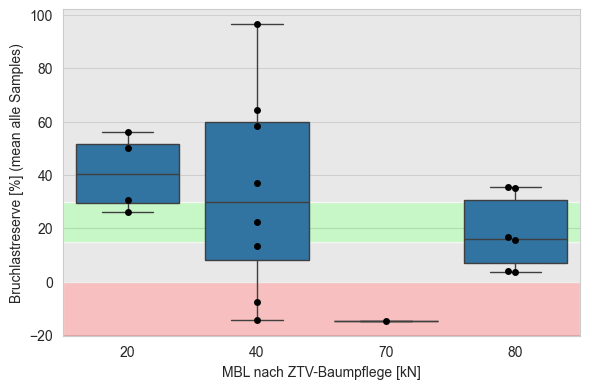

In [28]:
# Seaborn "deep" Palette holen
#deep_palette = sns.color_palette("deep", 4)

# Erstellen des Boxplots mit Punkten für jeden Sample
fig = plt.figure(figsize=(6, 4))
sns.boxplot(x='load_ztv', y='load_reserve_percent_mean', data=summary_df)  #palette=deep_palette)
sns.swarmplot(x='load_ztv', y='load_reserve_percent_mean', data=summary_df, color='k', alpha=1)

# Definieren der Bereiche und Farben
plt.axhspan(-1e6, 0, facecolor='lightcoral', alpha=0.5)
plt.axhspan(0, optimal_min, facecolor='lightgrey', alpha=0.5)
plt.axhspan(optimal_min, optimal_max, facecolor='lightgreen', alpha=0.5)
plt.axhspan(optimal_max, 1e6, facecolor='lightgrey', alpha=0.5)

# Titel und Achsenbeschriftungen hinzufügen
#plt.title('Mittlere Bruchlastreserven nach System in % der MBL nach ZTV')
plt.xlabel('MBL nach ZTV-Baumpflege [kN]')
plt.ylabel('Bruchlastreserve [%] (mean alle Samples)')
plt.tight_layout()

# Speichern des Plots
PLOT_MANAGER.save_plot(fig, filename=f"system_load_reserve_percent", subdir="mbl", auto_close=False)

# Plot anzeigen
plt.show()

In [29]:
# Auswahl der gewünschten Spalten
selected_columns = ['Variable', 'Anzahl', 'Prozent']
selected_systems_passed_df = systems_passed_df[selected_columns]

# Konvertierung des DataFrames in eine LaTeX-Tabelle
latex_string = selected_systems_passed_df.to_latex(index=False, escape=True, column_format="lrr",
                                                   float_format="{:0.2f}".format)

latex_table = f"""
\\begin{{table}}[h]
    \\caption{{Laborversuch - Systeme Bestanden}}
    \\centering
    {latex_string}
    \\label{{tab:Laborversuch_Systeme_Summary}}
\\end{{table}}
"""

print(latex_table)


\begin{table}[h]
    \caption{Laborversuch - Systeme Bestanden}
    \centering
    \begin{tabular}{lrr}
\toprule
Variable & Anzahl & Prozent \\
\midrule
Systeme gesamt & 19 & NaN \\
Systeme bestanden & 16 & 84.21 \\
Systeme nicht bestanden & 3 & 15.79 \\
Systeme überdimensioniert & 9 & 47.37 \\
Systeme optimal & 2 & 10.53 \\
\bottomrule
\end{tabular}

    \label{tab:Laborversuch_Systeme_Summary}
\end{table}


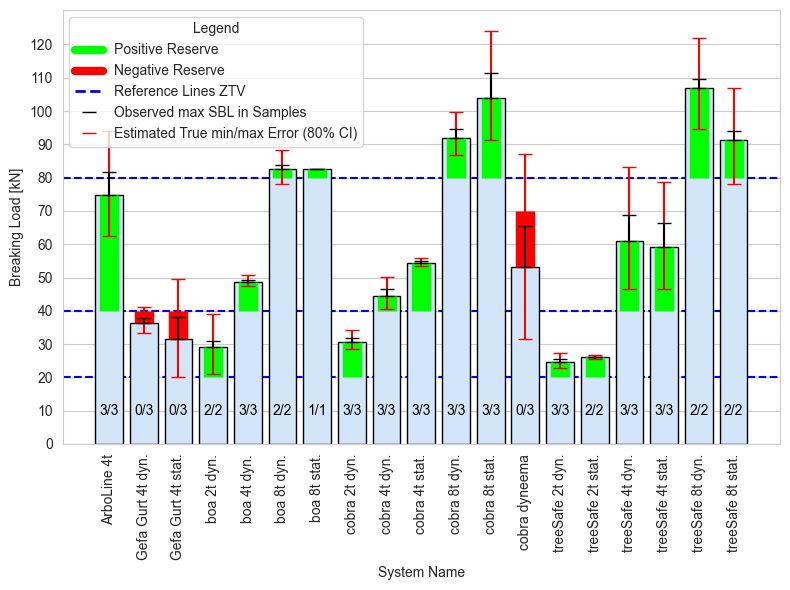

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot erstellen
fig = plt.figure(figsize=(8, 6))

# Balkendiagramm für minimale Werte
barplot = sns.barplot(data=summary_df, x='system_name', y='min_f_max', color='#cce5ff', edgecolor='black', zorder=2)


# Hinzufügen der Fehlerbalken für max_f_max
plt.errorbar(x=summary_df['system_name'], y=summary_df['min_f_max'],
             yerr=[summary_df['min_f_max'] - summary_df['min_f_max'],  # Abweichung nach unten
                   summary_df['max_f_max'] - summary_df['min_f_max']],  # Abweichung nach Oben
             fmt='none', c='black', capsize=5, zorder=5)

# Hinzufügen der Fehlerbalken für true_max_f_max und true_min_f_max
plt.errorbar(x=summary_df['system_name'], y=summary_df['min_f_max'],
             yerr=[summary_df['min_f_max'] - summary_df['true_min_f_max'],  # Abweichung nach unten
                   summary_df['true_max_f_max'] - summary_df['min_f_max']],  # Abweichung nach Oben
             fmt='none', c='red', capsize=5, zorder=4)

# Hinzufügen der Segmente für die Lastreserve
for index, row in summary_df.iterrows():
    plt.plot([index, index], [row['load_ztv'], row['load_ztv'] + row['load_reserve_min']],
             color=row['color'], linewidth=14, zorder=3, solid_capstyle="butt")

# Hinzufügen der Beschriftungen für das bestanden Verhältnis
for index, row in summary_df.iterrows():
    plt.text(x=index, y=10, s=row['passed_ratio'], ha='center', va='center', color='black', zorder=5)

# Horizontale Linien hinzufügen
for y in [20, 40, 80]:
    plt.axhline(y=y, color='blue', linestyle='--', zorder=1)

# Achsenbeschriftungen und Titel
plt.xlabel('System Name')
plt.ylabel('Breaking Load [kN]')
#plt.title('MBL of the weakest Sample for all Systems')
plt.xticks(rotation=90)

# Hinzufügen der Legende
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='#00ff00', lw=6, label='Positive Reserve'),
                   Line2D([0], [0], color='#ff0000', lw=6, label='Negative Reserve'),
                   Line2D([0], [0], color='blue', linestyle='--', lw=2, label='Reference Lines ZTV'),
                   Line2D([0], [0], color='black', lw=4, label='Observed max SBL in Samples', marker='_',
                          markersize=10, linestyle='None'),
                   Line2D([0], [0], color='red', lw=4, label='Estimated True min/max Error (80% CI)', marker='_',
                          markersize=10, linestyle='None')]
plt.legend(handles=legend_elements, title='Legend')

# Anpassen der y-Achse
plt.yticks(np.arange(0, 125, 10))
plt.tight_layout()

# Speichern des Plots
PLOT_MANAGER.save_plot(fig, filename=f"load_reserve", subdir="mbl", auto_close=False)

# Plot anzeigen
plt.show()

### Bruchlastreduktion durch Ruckdämpfer (cobra und boa)

In [31]:
df

,measurement_version_id,measurement_version_name,measurement_id,system_name,brand,selection_mode,selection_until,filter_flag,e_by_f_method,null_offset,...,e_at_load_ztv_100,e_by_f_2,e_by_f_4,e_by_f_8,e_by_f_16,load_reserve,load_reserve_percent,passed,oversize,optimal
0,1,version_for_mbl,64,cobra 4t stat.,cobra,default,end,True,interp1d,None,...,16.721131,5.210917,5.498906,6.447269,10.752325,14.810387,37.025968,True,True,False
1,2,version_for_mbl,65,cobra 4t stat.,cobra,default,end,True,interp1d,None,...,17.771215,5.943152,6.358988,7.323272,11.540141,14.488097,36.220241,True,True,False
2,3,version_for_mbl,66,cobra 4t stat.,cobra,default,end,True,interp1d,None,...,12.283144,4.056944,4.098026,4.941386,6.735708,15.047355,37.618388,True,True,False
3,4,version_for_mbl,67,cobra 4t dyn.,cobra,default,end,True,interp1d,None,...,14.994939,4.376078,4.841898,6.273778,8.487204,6.474645,16.186613,True,False,True
4,5,version_for_mbl,68,cobra 4t dyn.,cobra,default,end,True,interp1d,None,...,21.648537,8.109323,8.326631,9.976651,14.372544,4.345968,10.864920,True,False,False
5,6,version_for_mbl,69,cobra 4t dyn.,cobra,default,end,True,interp1d,None,...,19.899227,6.516411,7.076456,8.157480,12.939403,5.226935,13.067338,True,False,False
6,7,version_for_mbl,70,boa 4t dyn.,boa,default,end,True,interp1d,None,...,18.893841,6.835641,7.887014,21.249000,11.742563,9.361936,23.404839,True,False,True
7,8,version_for_mbl,71,boa 4t dyn.,boa,default,end,True,interp1d,None,...,21.130459,6.069429,7.241390,9.585325,13.464457,8.646709,21.616773,True,False,True
8,9,version_for_mbl,72,boa 4t dyn.,boa,default,end,True,interp1d,None,...,21.008517,5.135301,7.116228,9.652058,13.391109,8.782129,21.955323,True,False,True
9,10,version_for_mbl,73,treeSafe 4t stat.,drayer,default,end,True,interp1d,None,...,13.485629,3.364158,4.189945,5.291326,7.696250,19.197742,47.994355,True,True,False


In [32]:
df_cobra_boa = df[(df['brand'].isin(['boa', 'cobra'])) & (df['system_name'] != 'cobra dyneema')].copy()
selected_columns = ['measurement_id', 'system_name', 'brand', 'load_ztv', 'f_max', 'pre_tension_load', 'shock_absorber_count', 'shock_absorber_l_delta', 'failure_loc', 'load_reserve', 'load_reserve_percent']
df_cobra_boa = df_cobra_boa[selected_columns]
df_cobra_boa = df_cobra_boa.sort_values(by=['brand', 'load_ztv', 'measurement_id'])
df_cobra_boa

,measurement_id,system_name,brand,load_ztv,f_max,pre_tension_load,shock_absorber_count,shock_absorber_l_delta,failure_loc,load_reserve,load_reserve_percent
44,108,boa 2t dyn.,boa,20,30.879258,8,1,105,ruckdaempfer,10.879258,54.396290
45,109,boa 2t dyn.,boa,20,29.211581,8,1,98,ruckdaempfer,9.211581,46.057903
6,70,boa 4t dyn.,boa,40,49.361936,8,1,122,ruckdaempfer,9.361936,23.404839
7,71,boa 4t dyn.,boa,40,48.646709,8,1,120,ruckdaempfer,8.646709,21.616773
8,72,boa 4t dyn.,boa,40,48.782129,8,1,120,ruckdaempfer,8.782129,21.955323
41,105,boa 8t dyn.,boa,80,82.719548,16,1,68,ruckdaempfer,2.719548,3.399435
42,106,boa 8t dyn.,boa,80,83.686355,16,1,65,ruckdaempfer,3.686355,4.607943
43,107,boa 8t stat.,boa,80,82.729420,16,0,None,spleisende_rechts,2.729420,3.411775
18,82,cobra 2t dyn.,cobra,20,31.904839,8,1,190,ruckdaempfer,11.904839,59.524193
19,83,cobra 2t dyn.,cobra,20,31.023871,8,1,190,ruckdaempfer,11.023871,55.119355


In [33]:
# Gruppieren und Aggregieren
grouped = df_cobra_boa.groupby(['system_name', 'shock_absorber_count']).agg(
    n=('f_max', 'size'),
    mean=('f_max', 'mean'),
    sd=('f_max', 'std'),
    max=('f_max', 'max'),
    min=('f_max', 'min')
).reset_index()

# Sicherheitsniveau festlegen
confidence_level = 0.90
alpha = 1 - confidence_level

# Berechnung des Standardfehlers und der Fehlerbalken für das Konfidenzniveau
grouped['se'] = grouped['sd'] / np.sqrt(grouped['n'])
grouped['ci'] = grouped['se'] * t.ppf(1 - alpha/2, df=grouped['n']-1)
grouped

,system_name,shock_absorber_count,n,mean,sd,max,min,se,ci
0,boa 2t dyn.,1,2,30.045419,1.179226,30.879258,29.211581,0.833839,5.264650
1,boa 4t dyn.,1,3,48.930258,0.379926,49.361936,48.646709,0.219350,0.640500
2,boa 8t dyn.,1,2,83.202951,0.683636,83.686355,82.719548,0.483403,3.052089
3,boa 8t stat.,0,1,82.729420,NaN,82.729420,82.729420,NaN,NaN
4,cobra 2t dyn.,1,3,31.188699,0.649603,31.904839,30.637387,0.375049,1.095137
5,cobra 4t dyn.,1,3,45.349183,1.069591,46.474645,44.345968,0.617529,1.803175
6,cobra 4t stat.,0,3,54.781946,0.280712,55.047355,54.488097,0.162069,0.473240
7,cobra 8t dyn.,1,3,93.231323,1.469648,94.702581,91.763290,0.848502,2.477613
8,cobra 8t stat.,0,3,108.038205,3.730395,111.404903,104.027872,2.153745,6.288903


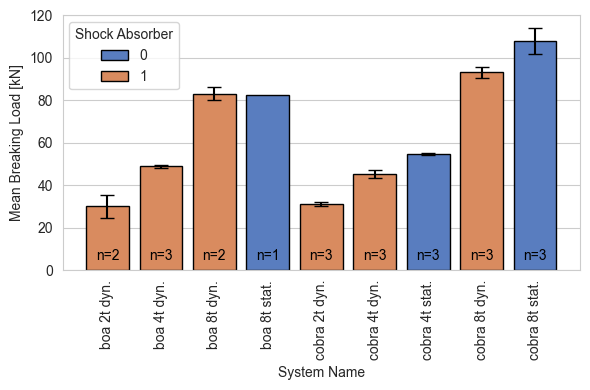

In [34]:
# Plot erstellen
fig = plt.figure(figsize=(6, 4))
plot = sns.barplot(
    data=grouped,
    x='system_name',
    y='mean',
    hue='shock_absorber_count',
    palette='muted',
    edgecolor='black',
    errorbar=None
)

# Fehlerbalken und Anzahl der Beobachtungen hinzufügen
for i in range(len(grouped)):
    plt.errorbar(
        x=i,
        y=grouped['mean'][i],
        yerr=grouped['ci'][i],
        fmt='none',
        c='black',
        capsize=5
    )
    plt.text(
        x=i,
        y=10,  # Position unten bei den Balken
        s=f'n={grouped["n"][i]}',
        color='black',
        ha='center',
        va='top'
    )

plot.set_xlabel("System Name")
plot.set_ylabel("Mean Breaking Load [kN]")
#plot.set_title(f"Mean Breaking Loads of Systems with {int(confidence_level*100)}% CI")

plt.xticks(rotation=90)
plt.legend(title='Shock Absorber')
plt.tight_layout()

# Speichern des Plots
PLOT_MANAGER.save_plot(fig, filename=f"system_mbl_shock_absorber", subdir="mbl", auto_close=False)
plt.show()

In [35]:
### Absolute Dehnung über Rückdämpfer

In [36]:
df_shock = df_cobra_boa[df_cobra_boa['shock_absorber_count'] == 1]
df_shock

,measurement_id,system_name,brand,load_ztv,f_max,pre_tension_load,shock_absorber_count,shock_absorber_l_delta,failure_loc,load_reserve,load_reserve_percent
44,108,boa 2t dyn.,boa,20,30.879258,8,1,105,ruckdaempfer,10.879258,54.396290
45,109,boa 2t dyn.,boa,20,29.211581,8,1,98,ruckdaempfer,9.211581,46.057903
6,70,boa 4t dyn.,boa,40,49.361936,8,1,122,ruckdaempfer,9.361936,23.404839
7,71,boa 4t dyn.,boa,40,48.646709,8,1,120,ruckdaempfer,8.646709,21.616773
8,72,boa 4t dyn.,boa,40,48.782129,8,1,120,ruckdaempfer,8.782129,21.955323
41,105,boa 8t dyn.,boa,80,82.719548,16,1,68,ruckdaempfer,2.719548,3.399435
42,106,boa 8t dyn.,boa,80,83.686355,16,1,65,ruckdaempfer,3.686355,4.607943
18,82,cobra 2t dyn.,cobra,20,31.904839,8,1,190,ruckdaempfer,11.904839,59.524193
19,83,cobra 2t dyn.,cobra,20,31.023871,8,1,190,ruckdaempfer,11.023871,55.119355
20,84,cobra 2t dyn.,cobra,20,30.637387,8,1,190,ruckdaempfer,10.637387,53.186936


In [37]:
# Prüfen, wie viele Einträge 'failure_loc' gleich 'ruckdaempfer' haben
total_entries = len(df_shock)
matching_entries = (df_shock['failure_loc'] == 'ruckdaempfer').sum()

print(f"{matching_entries} von {total_entries} Einträgen haben 'failure_loc' gleich 'ruckdaempfer'.")

16 von 16 Einträgen haben 'failure_loc' gleich 'ruckdaempfer'.


In [38]:
# Gruppieren und Aggregieren
grouped = df_shock.groupby(['system_name', 'load_ztv', 'pre_tension_load']).agg(
    n=('shock_absorber_l_delta', 'size'),
    mean=('shock_absorber_l_delta', 'mean'),
    sd=('shock_absorber_l_delta', 'std'),
    max=('shock_absorber_l_delta', 'max'),
    min=('shock_absorber_l_delta', 'min')
).reset_index()

# Sicherheitsniveau festlegen
confidence_level = 0.90
alpha = 1 - confidence_level

# Berechnung des Standardfehlers und der Fehlerbalken für das Konfidenzniveau
grouped['se'] = grouped['sd'] / np.sqrt(grouped['n'])
grouped['ci'] = grouped['se'] * t.ppf(1 - alpha/2, df=grouped['n']-1)
grouped

,system_name,load_ztv,pre_tension_load,n,mean,sd,max,min,se,ci
0,boa 2t dyn.,20,8,2,101.5,4.949747,105,98,3.500000,22.098130
1,boa 4t dyn.,40,8,3,120.666667,1.154701,122,120,0.666667,1.946657
2,boa 8t dyn.,80,16,2,66.5,2.121320,68,65,1.500000,9.470627
3,cobra 2t dyn.,20,8,3,190.0,0.000000,190,190,0.000000,0.000000
4,cobra 4t dyn.,40,8,3,101.0,5.567764,107,96,3.214550,9.386440
5,cobra 8t dyn.,80,16,3,98.666667,7.094599,105,91,4.096069,11.960461


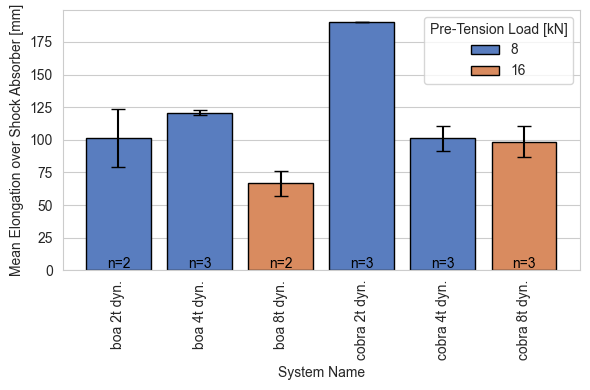

In [39]:
# Plot erstellen
fig = plt.figure(figsize=(6, 4))
plot = sns.barplot(
    data=grouped,
    x='system_name',
    y='mean',
    hue='pre_tension_load',
    palette='muted',
    edgecolor='black',
    errorbar=None
)

# Fehlerbalken und Anzahl der Beobachtungen hinzufügen
for i in range(len(grouped)):
    plt.errorbar(
        x=i,
        y=grouped['mean'][i],
        yerr=grouped['ci'][i],
        fmt='none',
        c='black',
        capsize=5
    )
    plt.text(
        x=i,
        y=10,  # Position unten bei den Balken
        s=f'n={grouped["n"][i]}',
        color='black',
        ha='center',
        va='top'
    )

plot.set_xlabel("System Name")
plot.set_ylabel("Mean Elongation over Shock Absorber [mm]")
#plot.set_title(f"Mean Elongation over Shock Absorber at Pre-Tension Load with  {int(confidence_level*100)}% CI")

plt.xticks(rotation=90)
plt.legend(title='Pre-Tension Load [kN]')
plt.tight_layout()

# Speichern des Plots
PLOT_MANAGER.save_plot(fig, filename=f"elongation_shock_absorber", subdir="mbl", auto_close=False)

plt.show()